In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import os
import numpy as np
import cartopy.crs as ccrs
from shared_astro_utils import matching_utils
from astropy import units as u
from PIL import Image
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_context('notebook')

In [5]:
os.chdir('/home/walml/repos/zoobot')

In [6]:
gz2 = pd.read_csv('data/gz2/gz2_classifications_and_subjects.csv')

dr2 = pd.read_parquet('current_final_dr2_result.parquet')

dr5 = pd.read_parquet('current_final_dr5_result.parquet')

In [7]:
len(gz2), len(dr2), len(dr5)  # aggregated by galaxy already

(239695, 92960, 253286)

In [8]:
dr5_retired = dr5[dr5['smooth-or-featured_total-votes'] > 36]
len(dr5_retired)

52326

In [9]:
dr2_retired = dr2[dr2['smooth-or-featured_total-votes'] > 36]
len(dr2_retired)

55458

In [10]:
dr5_retired['upload_group'].value_counts()

pre_active         44878
active_priority     6072
targeted            1083
active_baseline      174
calibration          119
Name: upload_group, dtype: int64

In [11]:
dr5_pre_active = dr5_retired.query('upload_group == "pre_active"')

In [12]:
# in this case, we'll use the dr5 classifications if available, otherwise dr2

In [13]:
dr2['iauname'].isin(dr5_pre_active['iauname']).sum()

5515

In [14]:
# dr2_only = dr2[~dr2['iauname'].isin(dr5_pre_active['iauname'])]
# decals = pd.concat([dr5_pre_active, dr2_only], axis=0)

In [15]:
decals = dr2

In [16]:
decals.sample(5)

,subject_id,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,how-rounded_completely,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,dec,petro_theta,petro_th50,petro_th90,elpetro_absmag_r,sersic_nmgy_r,redshift,active_learning_on,upload_group,in_gzd_c
50836,56f3dc1c5925d90042022255,31,2,4,27,4,0,0,2,0,...,3.998177,4.871721,2.116105,6.829268,-20.355999,296.165558,0.075029,False,pre_active,False
15720,55a7d7aa7a726119cd004a0f,44,7,5,7,37,0,2,5,1,...,30.334372,6.177674,2.813898,8.345883,-18.756456,138.325699,0.049784,False,pre_active,False
13282,55a7d7a87a726119cd003e00,47,2,5,4,40,3,1,1,0,...,0.254017,3.336901,1.594149,4.436659,-17.055517,43.751015,0.039748,False,pre_active,False
53044,56f3dc3f5925d900420233b3,25,9,5,21,4,0,0,9,0,...,27.610823,5.891101,2.813898,5.329020,-19.424496,83.392876,0.080175,False,pre_active,False
50819,56f3dc1c5925d90042022233,23,4,6,2,21,0,0,4,0,...,3.994275,5.330101,2.345714,5.460339,-20.195295,133.603867,0.086988,False,pre_active,True


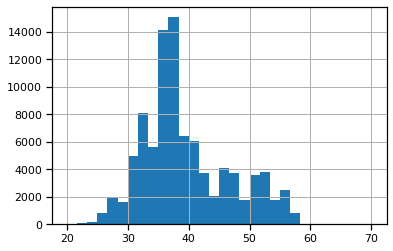

In [17]:
decals['smooth-or-featured_total-votes'].hist(bins=30)

In [18]:
decals['smooth-or-featured_featured-or-disk_fraction']

0        0.384615
1        0.055556
2        0.024390
3        0.285714
4        0.117647
           ...   
92955    0.428571
92956    0.375000
92957    0.384615
92958    0.057143
92959    0.729730
Name: smooth-or-featured_featured-or-disk_fraction, Length: 92960, dtype: float64

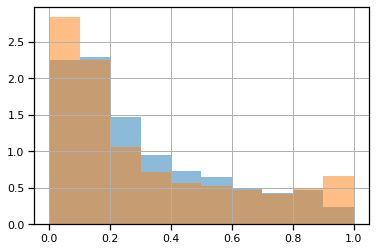

In [19]:
decals['smooth-or-featured_featured-or-disk_fraction'].hist(range=[0., 1.], alpha=.5, density=True)
gz2['t01_smooth_or_features_a02_features_or_disk_fraction'].hist(range=[0., 1.], alpha=.5, density=True)

Not that big a shift - but remember decals goes much deeper! Let's crossmatch

In [20]:
decals_gz2, _ = matching_utils.match_galaxies_to_catalog_pandas(decals, gz2)
len(decals_gz2)

32794

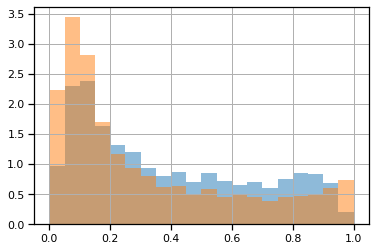

In [21]:
bins = 20
decals_gz2['smooth-or-featured_featured-or-disk_fraction'].hist(range=[0., 1.], alpha=.5, density=True, bins=bins)
gz2['t01_smooth_or_features_a02_features_or_disk_fraction'].hist(range=[0., 1.], alpha=.5, density=True, bins=bins)

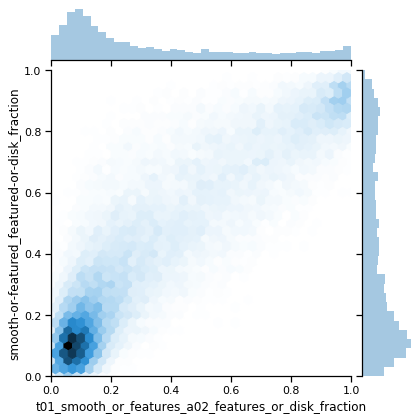

In [22]:

g = sns.jointplot(data=decals_gz2, y='smooth-or-featured_featured-or-disk_fraction', x='t01_smooth_or_features_a02_features_or_disk_fraction', kind='hex', xlim=[0., 1.], ylim=[0., 1.])

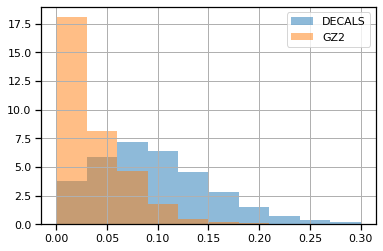

In [23]:
decals_gz2['smooth-or-featured_artifact_fraction'].hist(range=[0., .3], density=True, alpha=.5, label='DECALS')
decals_gz2['t01_smooth_or_features_a03_star_or_artifact_fraction'].hist(range=[0., .3], density=True, alpha=.5, label='GZ2')
plt.legend()

Text(23.125, 0.5, 'GZ DECaLS "Featured" fraction')

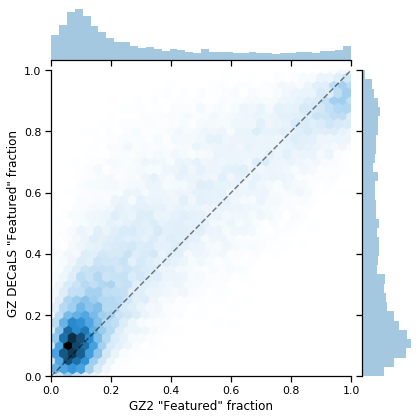

In [24]:
g = sns.jointplot(data=decals_gz2, y='smooth-or-featured_featured-or-disk_fraction', x='t01_smooth_or_features_a02_features_or_disk_fraction', kind='hex', xlim=[0., 1.], ylim=[0., 1.])
# https://github.com/mwaskom/seaborn/blob/master/seaborn/axisgrid.py#L1741
g.ax_joint.plot([0, 1.], [0., 1.], 'k--', alpha=.5)
g.ax_joint.set_xlabel('GZ2 "Featured" fraction')
g.ax_joint.set_ylabel('GZ DECaLS "Featured" fraction')
# plt.savefig('featured_comparison.pdf')
# plt.savefig('featured_comparison.png')

In [29]:
decals_gz2['decals_smooth_vs_featured_fraction'] = decals_gz2['smooth-or-featured_featured-or-disk_fraction'] / (decals_gz2['smooth-or-featured_smooth_fraction'] + decals_gz2['smooth-or-featured_featured-or-disk_fraction'])
decals_gz2['gz2_smooth_vs_featured_fraction'] = decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction'] / (decals_gz2['t01_smooth_or_features_a01_smooth_fraction'] + decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction'])

Text(23.125, 0.5, 'GZ DECaLS "Featured" fraction (excl. artifact)')

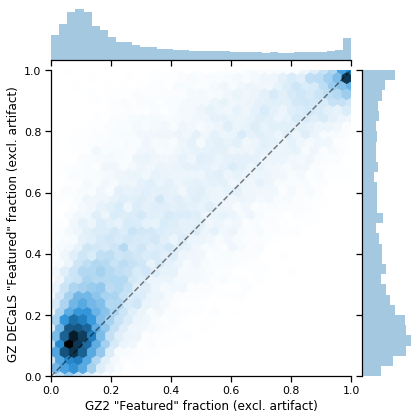

In [31]:
g = sns.jointplot(data=decals_gz2, y='decals_smooth_vs_featured_fraction', x='gz2_smooth_vs_featured_fraction', kind='hex', xlim=[0., 1.], ylim=[0., 1.])
# https://github.com/mwaskom/seaborn/blob/master/seaborn/axisgrid.py#L1741
g.ax_joint.plot([0, 1.], [0., 1.], 'k--', alpha=.5)
g.ax_joint.set_xlabel('GZ2 "Featured" fraction (excl. artifact)')
g.ax_joint.set_ylabel('GZ DECaLS "Featured" fraction (excl. artifact)')

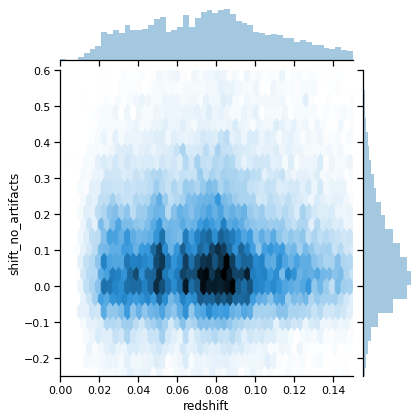

In [37]:
decals_gz2['shift_no_artifacts'] = decals_gz2['decals_smooth_vs_featured_fraction'] - decals_gz2['gz2_smooth_vs_featured_fraction']

g = sns.jointplot(data=decals_gz2, y='shift_no_artifacts', x='redshift', kind='hex', xlim=[.0, .15], ylim=[-.25, .6])

In [141]:
bins = 15

decals_gz2['redshift_bins'] = pd.cut(decals_gz2['redshift'], bins=bins)
decals_gz2['redshift_bin_center'] = decals_gz2['redshift_bins'].apply(lambda x: float(x.left + ((x.right - x.left)/2)))

In [142]:
redshift_df['redshift_bin_center'] = redshift_df['redshift_bin_center'].astype(float)

In [143]:
list(redshift_df['redshift_bin_center'].values)

[0.007410999999999999,
 0.0225,
 0.0375,
 0.0525,
 0.0675,
 0.08249999999999999,
 0.0975,
 0.11249999999999999,
 0.1275,
 0.14250000000000002]

In [144]:
np.array(redshift_df['redshift_bin_center']) > .5

array([False, False, False, False, False, False, False, False, False,
       False])

Text(0, 0.5, '"Featured" fraction shift')

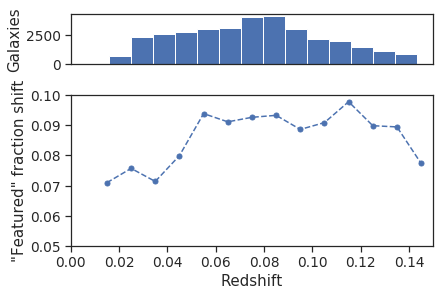

In [147]:


redshift_df = decals_gz2.groupby('redshift_bin_center').agg({'shift_no_artifacts': 'mean'}).reset_index()
above_low_z = redshift_df[np.array(redshift_df['redshift_bin_center']) > .01]
# above_low_z = redshift_df

sns.set(font_scale=1.25, context='notebook')
sns.set_style('ticks')
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(4, 3)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1:, :])


ax0.hist(decals_gz2['redshift'], bins=bins)
ax0.axes.get_xaxis().set_visible(False)
ax0.set_ylabel('Galaxies')

ax1.plot(np.array(redshift_df['redshift_bin_center'])[1:], above_low_z['shift_no_artifacts'], marker='.', markersize=10., linestyle='--')
# plt.axhline(0., linestyle='--', color='k')
ax1.set_ylim([.05, .1])
ax1.set_xlim([0., .15])
ax1.set_xlabel('Redshift')
ax1.set_ylabel('"Featured" fraction shift')

In [101]:
# fig, ax = plt.subplots(with sns.color_palette("Blues"):
#     plt.hexbin(decals_gz2['smooth-or-featured_featured-or-disk_fraction'], decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction'], gridsize=30, cmap='Blues')
#     # cmap=sns.color_palette("Blues")

In [ ]:
decals_gz2['gz2_png_loc'] = decals_gz2['png_loc'].apply(lambda x: x.replace('/Volumes/alpha', '/media/walml/beta/galaxy_zoo'))
decals_gz2['gz2_png_loc']

In [ ]:
decals_gz2['decals_png_loc'] = decals_gz2['iauname'].apply(lambda x: '/media/walml/beta/decals/png_native/dr5/' + x[:4] + '/' + x + '.png')
decals_gz2['decals_png_loc']

In [ ]:
def show_image_comparison(df, num_galaxies=5):
    df = df.query('both_images_exist')
    scale = 3.
    plt.figure(figsize=(scale * 2, scale * num_galaxies * 1.025))
    gs1 = gridspec.GridSpec(num_galaxies, 2)
    gs1.update(wspace=0.0, hspace=0.0)
    text_locs = (30, 60)
    size = 14
    for row_n in range(num_galaxies):
        
        galaxy = df.iloc[row_n]
        
        data = np.array(Image.open(galaxy['gz2_png_loc']))
        ax = plt.subplot(gs1[row_n, 0])
        ax.imshow(data)
        ax.axis('off')
        ax.text(*text_locs, 'GZ2: {:.2f}'.format(galaxy['t01_smooth_or_features_a02_features_or_disk_fraction']), color='r', size=size)
        
        data = np.array(Image.open(galaxy['decals_png_loc']))
        ax = plt.subplot(gs1[row_n, 1])
        ax.imshow(data)
        ax.axis('off')
        ax.text(*text_locs, 'DECaLS:{:.2f}'.format(galaxy['smooth-or-featured_featured-or-disk_fraction']), color='r', size=size)
        



In [ ]:
decals_gz2['change_in_featured_frac'] = decals_gz2['smooth-or-featured_featured-or-disk_fraction'] - decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction']
somewhat_featured = decals_gz2[(decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction'] > 0.25) & (decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction'] < 0.75)]
len(decals_gz2), len(somewhat_featured)

In [ ]:
median_pc_increase = (somewhat_featured['change_in_featured_frac'] / decals_gz2['smooth-or-featured_featured-or-disk_fraction']).median()
median_pc_increase

In [ ]:
median_increase = somewhat_featured['change_in_featured_frac'].median()
median_increase

In [ ]:
show_image_comparison(somewhat_featured.sample(10))

In [ ]:
decals_gz2['gz2_png_exists'] = decals_gz2['gz2_png_loc'].apply(os.path.isfile)
decals_gz2['decals_png_exists'] = decals_gz2['decals_png_loc'].apply(os.path.isfile)
decals_gz2['both_images_exist'] = decals_gz2['gz2_png_exists'] & decals_gz2['decals_png_exists']

In [ ]:
bad_iaunames = ['J152639.16+010632.0']  # dodgy images

In [ ]:
decals_gz2 = decals_gz2[~decals_gz2['iauname'].isin(bad_iaunames)]

In [ ]:

show_image_comparison(decals_gz2.sort_values('change_in_featured_frac', ascending=False))

In [ ]:
decals_gz2['change_in_featured_frac'] = decals_gz2['smooth-or-featured_featured-or-disk_fraction'] - decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction']
show_image_comparison(decals_gz2.sort_values('change_in_featured_frac', ascending=False)[:1000].sample(10), num_galaxies=6)
# plt.gcf().savefig('featured_galaxies_big_shift.pdf')
# plt.gcf().savefig('featured_galaxies_big_shift.png')

In [ ]:
decals_gz2.columns.values

In [ ]:
## and for featured galaxies

In [ ]:
featured = decals_gz2[(decals_gz2['t01_smooth_or_features_a02_features_or_disk_fraction'] > .5) & (decals_gz2['smooth-or-featured_featured-or-disk_fraction'] > 0.5)]
featured['t04_spiral_a08_spiral_fraction'].hist(alpha=.5, density=True, label='GZ2', bins=30)
featured['has-spiral-arms_yes_fraction'].hist(alpha=.5, density=True, label='DECALS', bins=30)
plt.legend()
plt.xlim([0., 1.])

In [ ]:
featured['t04_spiral_a08_spiral_fraction'].median(), featured['has-spiral-arms_yes_fraction'].median()

In [ ]:
featured['t04_spiral_a08_spiral_fraction'].median(), featured['has-spiral-arms_yes_fraction'].median()

In [ ]:

featured['t03_bar_a06_bar_fraction'].hist(alpha=.5, density=True, label='GZ2', bins=30)
featured['bar_yes_fraction'].hist(alpha=.5, density=True, label='DECALS', bins=30)
plt.legend()
plt.xlim([0., 1.])

In [ ]:
featured['t03_bar_a06_bar_fraction'].median(), featured['bar_yes_fraction'].median()

In [ ]:

featured['t11_arms_number_a37_cant_tell_fraction'].hist(alpha=.5, density=True, label='GZ2', bins=30)
featured['spiral-arm-count_cant-tell_fraction'].hist(alpha=.5, density=True, label='DECALS', bins=30)
plt.legend()
plt.xlim([0., 1.])

In [ ]:

g = sns.joifeatured['has-spiral-arms_yes_fraction'].hist()ntplot(data=decals_gz2, y='has-spiral-arms_yes_fraction', x='t01_smooth_or_features_a02_features_or_disk_fraction', kind='hex', xlim=[0., 1.], ylim=[0., 1.])
# https://github.com/mwaskom/seaborn/blob/master/seaborn/axisgrid.py#L1741
g.ax_joint.plot([0, 1.], [0., 1.], 'k--', alpha=.5)
# g.ax_joint.set_xlabel('GZ2 "Featured" fraction')
# g.ax_joint.set_ylabel('GZ DECaLS "Featured" fraction')
# plt.savefig('featured_comparison.pdf')
# plt.savefig('featured_comparison.png')